In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import shutil 
from tqdm import tqdm
import matplotlib.pyplot as plt
import cv2

import albumentations as A 

import torch, torchvision
from torch.utils.data import DataLoader
from torchvision import models, transforms, datasets
from torchvision.transforms import functional as F

import os, time, copy

In [2]:
data_root = 'D:/kaggle_data/sobes/journey-springfield/'
print(os.listdir(data_root))

['characters_illustration.png', 'sample_submission.csv', 'testset', 'train', 'trainset', 'train_augmentation', 'val']


In [3]:
train_dir = 'train'
val_dir = 'val'
train_dataset = 'trainset/simpsons_dataset'

class_names = os.listdir(os.path.join(data_root, train_dataset)) #create list with class names

In [4]:
def visualize(image):
    image = cv2.imread(image)
    plt.figure(figsize=(10, 10))
    plt.axis('off')
    plt.imshow(image)

In [5]:
# find characters who have few images
characters_img = {}
for class_name in class_names:
    characters_img[class_name] = len(os.listdir(os.path.join(data_root, train_dataset, class_name)))

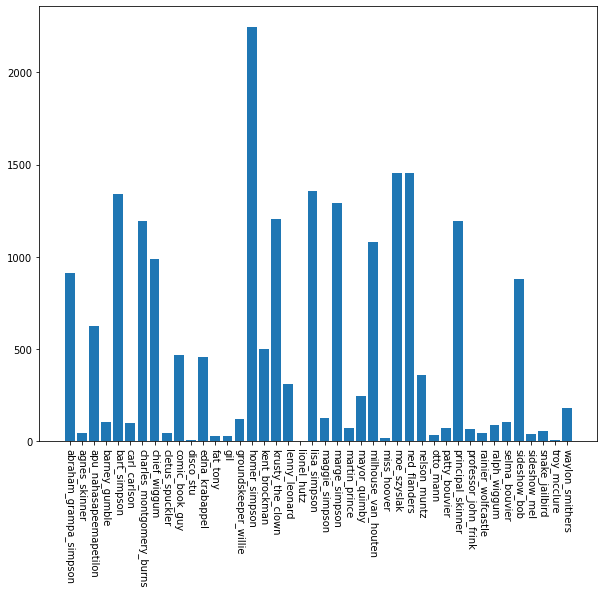

In [6]:
plt.subplots(figsize=(10,8))
plt.bar(range(len(characters_img)), characters_img.values())
plt.xticks(range(len(characters_img)), characters_img.keys(), rotation=-90)
plt.show()

In [7]:
# we see that some characters has few images for model training
# let's find them
characters_augm = []
for i in characters_img:
    if characters_img[i] <= 400:
        characters_augm.append(i)
print('{} out of {} have few images in their class'.format(len(characters_augm), len(class_names)))        

25 out of 42 have few images in their class


In [8]:
# copy images that create augmentation folder
for class_name in class_names:
        os.makedirs(os.path.join(data_root, 'train_augmentation', class_name), exist_ok=True)

for class_name in class_names:
    source_dir = os.path.join(data_root, train_dataset, class_name)
    dest_dir = os.path.join(data_root, 'train_augmentation', class_name)
    for i, file_name in enumerate(tqdm(os.listdir(source_dir))):
        if file_name not in os.listdir(dest_dir):
            shutil.copy(os.path.join(source_dir, file_name), os.path.join(dest_dir, file_name))
        #else:
        #    if i % 100 == 0:
        #            print('Files exist in folder'.format(file_name))

100%|██████████| 181/181 [00:00<00:00, 363.01it/s]


In [9]:
start_augm = False
for augm_class in characters_augm:
    augm_dir = os.path.join(data_root, 'train_augmentation', augm_class)
    transform = A.Compose([
    A.CLAHE(p=0.2),
    #A.HorizontalFlip(p=0.2),
    A.RandomBrightnessContrast(p=0.2),
    A.MotionBlur(p=0.2),
    A.Sharpen(p=0.5),
    A.RandomContrast(p=0.2),
    A.OpticalDistortion(p=0.5),
    #A.GridDistortion(p=0.5),
    ])
    augm_dir = os.path.join(data_root, 'train_augmentation', augm_class)
    if start_augm == True:
        for x in range(3):
            for i, file_name in enumerate(tqdm(os.listdir(augm_dir))):
                image = cv2.imread(os.path.join(augm_dir, file_name))
                #image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                transformed = transform(image=image)
                cv2.imwrite(os.path.join(augm_dir, '{}_aug_{}.jpg'.format(file_name, x)), transformed['image'])

                r = np.random.choice(500)
                if i == r:
                    fig, axes = plt.subplots(nrows=1, ncols=1, squeeze=False)      
                    # Representation
                    sample = cv2.cvtColor(transformed['image'], cv2.COLOR_BGR2RGB)
                    axes[0, 0].imshow(sample)
    


c:\Users\kinkp\Envs\torch\lib\site-packages\albumentations\augmentations\transforms.py:1175: FutureWarning: RandomContrast has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(


In [10]:
# create training and validation folders with images
for dir_name in [train_dir, val_dir]:
    for class_name in class_names:
        os.makedirs(os.path.join(data_root, dir_name, class_name), exist_ok=True)

for class_name in class_names:
    source_dir = os.path.join(data_root, 'train_augmentation', class_name)
    for i, file_name in enumerate(tqdm(os.listdir(source_dir))):
        if i % 6 != 0:
            dest_dir = os.path.join(data_root, train_dir, class_name) 
        else:
            dest_dir = os.path.join(data_root, val_dir, class_name)
        shutil.copy(os.path.join(source_dir, file_name), os.path.join(dest_dir, file_name))

100%|██████████| 1448/1448 [00:07<00:00, 191.77it/s]


In [11]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    train_dir: transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    val_dir: transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = data_root
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in [train_dir, val_dir]}
dataloaders = {x: DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in [train_dir, val_dir]}
dataset_sizes = {x: len(image_datasets[x]) for x in [train_dir, val_dir]}
class_names = image_datasets[train_dir].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

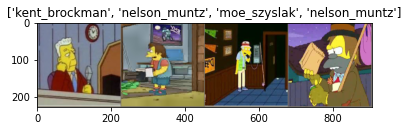

In [12]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders[train_dir]))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [13]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in tqdm(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [14]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [15]:
model = models.vgg16_bn(pretrained=True)

c:\Users\kinkp\Envs\torch\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\kinkp\Envs\torch\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to C:\Users\kinkp/.cache\torch\hub\checkpoints\vgg16_bn-6c64b313.pth
100%|██████████| 528M/528M [01:12<00:00, 7.67MB/s] 


In [31]:
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

In [37]:

for param in model.parameters():
    param.requires_grad = False
    
# Parameters of newly constructed modules have requires_grad=True by default
#num_ftrs = model.fc.in_features
num_ftrs = model.classifier[6].in_features
#model.fc = torch.nn.Linear(in_features=num_ftrs, out_features=len(class_names))
model.classifier[6] = torch.nn.Linear(in_features=num_ftrs, out_features=len(class_names))

model = model.to(device)

criterion = torch.nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [39]:
for name, param in model.named_parameters():
    if 'classifier' in name:
        param.requires_grad = True

In [40]:
for name, param in model.named_parameters():
    if param.requires_grad == True:
        print(name)

classifier.0.weight
classifier.0.bias
classifier.3.weight
classifier.3.bias
classifier.6.weight
classifier.6.bias


In [41]:
model = train_model(model, criterion, optimizer,
                         exp_lr_scheduler, num_epochs=20)

Epoch 0/19
----------


100%|██████████| 7710/7710 [06:56<00:00, 18.49it/s]


train Loss: 1.4315 Acc: 0.6075


100%|██████████| 1547/1547 [01:02<00:00, 24.56it/s]


val Loss: 0.6636 Acc: 0.8214

Epoch 1/19
----------


100%|██████████| 7710/7710 [06:55<00:00, 18.54it/s]


train Loss: 0.5889 Acc: 0.8326


100%|██████████| 1547/1547 [01:02<00:00, 24.65it/s]


val Loss: 0.4964 Acc: 0.8679

Epoch 2/19
----------


100%|██████████| 7710/7710 [06:55<00:00, 18.58it/s]


train Loss: 0.3804 Acc: 0.8890


100%|██████████| 1547/1547 [01:02<00:00, 24.82it/s]


val Loss: 0.3772 Acc: 0.9029

Epoch 3/19
----------


100%|██████████| 7710/7710 [06:52<00:00, 18.69it/s]


train Loss: 0.2711 Acc: 0.9216


100%|██████████| 1547/1547 [01:01<00:00, 25.20it/s]


val Loss: 0.3475 Acc: 0.9088

Epoch 4/19
----------


100%|██████████| 7710/7710 [06:50<00:00, 18.80it/s]


train Loss: 0.2168 Acc: 0.9364


100%|██████████| 1547/1547 [01:02<00:00, 24.67it/s]


val Loss: 0.3484 Acc: 0.9106

Epoch 5/19
----------


100%|██████████| 7710/7710 [06:55<00:00, 18.57it/s]


train Loss: 0.1791 Acc: 0.9479


100%|██████████| 1547/1547 [01:02<00:00, 24.71it/s]


val Loss: 0.3178 Acc: 0.9155

Epoch 6/19
----------


100%|██████████| 7710/7710 [06:54<00:00, 18.58it/s]


train Loss: 0.1524 Acc: 0.9548


100%|██████████| 1547/1547 [01:02<00:00, 24.76it/s]


val Loss: 0.4683 Acc: 0.9114

Epoch 7/19
----------


100%|██████████| 7710/7710 [06:52<00:00, 18.71it/s]


train Loss: 0.0763 Acc: 0.9768


100%|██████████| 1547/1547 [01:02<00:00, 24.74it/s]


val Loss: 0.2398 Acc: 0.9387

Epoch 8/19
----------


100%|██████████| 7710/7710 [06:52<00:00, 18.71it/s]


train Loss: 0.0530 Acc: 0.9839


100%|██████████| 1547/1547 [01:02<00:00, 24.81it/s]


val Loss: 0.3143 Acc: 0.9347

Epoch 9/19
----------


100%|██████████| 7710/7710 [06:54<00:00, 18.61it/s]


train Loss: 0.0437 Acc: 0.9873


100%|██████████| 1547/1547 [01:02<00:00, 24.80it/s]


val Loss: 0.5119 Acc: 0.9206

Epoch 10/19
----------


100%|██████████| 7710/7710 [06:38<00:00, 19.34it/s]


train Loss: 0.0395 Acc: 0.9884


100%|██████████| 1547/1547 [01:00<00:00, 25.71it/s]


val Loss: 0.2343 Acc: 0.9431

Epoch 11/19
----------


100%|██████████| 7710/7710 [06:35<00:00, 19.52it/s]


train Loss: 0.0347 Acc: 0.9893


100%|██████████| 1547/1547 [01:01<00:00, 25.15it/s]


val Loss: 0.2908 Acc: 0.9373

Epoch 12/19
----------


100%|██████████| 7710/7710 [06:52<00:00, 18.70it/s]


train Loss: 0.0305 Acc: 0.9909


100%|██████████| 1547/1547 [01:02<00:00, 24.95it/s]


val Loss: 0.2944 Acc: 0.9397

Epoch 13/19
----------


100%|██████████| 7710/7710 [06:50<00:00, 18.79it/s]


train Loss: 0.0314 Acc: 0.9908


100%|██████████| 1547/1547 [01:01<00:00, 25.16it/s]


val Loss: 0.3854 Acc: 0.9318

Epoch 14/19
----------


100%|██████████| 7710/7710 [06:52<00:00, 18.68it/s]


train Loss: 0.0275 Acc: 0.9919


100%|██████████| 1547/1547 [01:02<00:00, 24.59it/s]


val Loss: 0.2737 Acc: 0.9400

Epoch 15/19
----------


100%|██████████| 7710/7710 [06:54<00:00, 18.61it/s]


train Loss: 0.0256 Acc: 0.9920


100%|██████████| 1547/1547 [01:07<00:00, 22.97it/s]


val Loss: 0.2327 Acc: 0.9455

Epoch 16/19
----------


100%|██████████| 7710/7710 [06:57<00:00, 18.46it/s]


train Loss: 0.0276 Acc: 0.9919


100%|██████████| 1547/1547 [01:02<00:00, 24.76it/s]


val Loss: 0.3297 Acc: 0.9358

Epoch 17/19
----------


100%|██████████| 7710/7710 [06:54<00:00, 18.59it/s]


train Loss: 0.0274 Acc: 0.9919


100%|██████████| 1547/1547 [01:02<00:00, 24.72it/s]


val Loss: 0.3248 Acc: 0.9349

Epoch 18/19
----------


100%|██████████| 7710/7710 [06:53<00:00, 18.65it/s]


train Loss: 0.0279 Acc: 0.9921


100%|██████████| 1547/1547 [01:03<00:00, 24.54it/s]


val Loss: 0.2268 Acc: 0.9455

Epoch 19/19
----------


100%|██████████| 7710/7710 [06:52<00:00, 18.69it/s]


train Loss: 0.0256 Acc: 0.9923


100%|██████████| 1547/1547 [01:02<00:00, 24.70it/s]

val Loss: 0.2837 Acc: 0.9400

Training complete in 158m 11s
Best val Acc: 0.945531


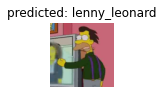

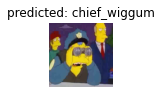

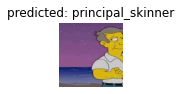

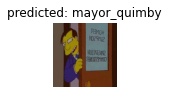

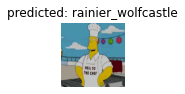

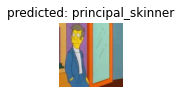

In [42]:
visualize_model(model)

plt.ioff()
plt.show()

In [43]:
test_dir = 'testset'
shutil.copytree(os.path.join(data_root, test_dir, 'testset'), os.path.join(data_root, 'test', 'unknown'))

'D:/kaggle_data/sobes/journey-springfield/test\\unknown'

In [45]:
data_dir

'D:/kaggle_data/sobes/journey-springfield/'

In [46]:
test_image_datasets = datasets.ImageFolder(os.path.join(data_dir, 'test'), data_transforms[val_dir])
test_dataloaders = DataLoader(test_image_datasets, batch_size=4, shuffle=False, num_workers=4)
test_dataset_sizes = len(test_image_datasets)
#class_names = test_image_datasets.classes

In [47]:
submission = pd.DataFrame(columns=['Id', 'Expected'])

In [48]:
def predict_model(model):
    was_training = model.training
    model.eval()
    pred_classes = []

    with torch.no_grad():
        for i, (inputs, _) in tqdm(enumerate(test_dataloaders)):
            inputs = inputs.to(device)
            
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                #submission = pd.concat([submission, pd.DataFrame([[inputs.cpu().data[j], 
                #                                                  class_names[preds[j]]]], columns=['Id', 'Expected'])])
                #print(test_dataloaders.dataset.imgs[j][0].split('\\')[-1])
                pred_classes.append(class_names[preds[j]])
                
                

                
        model.train(mode=was_training)
    
    return pred_classes

In [49]:
pred_classes = predict_model(model)

248it [00:08, 29.30it/s]


In [50]:
img_names = [test_dataloaders.dataset.imgs[i][0].split('\\')[-1] for i in range(len(pred_classes))]

In [51]:
submission['Id'], submission['Expected'] = img_names, pred_classes

In [52]:
submission.sample(5)

,Id,Expected
309,img377.jpg,ned_flanders
651,img685.jpg,nelson_muntz
761,img784.jpg,chief_wiggum
72,img163.jpg,comic_book_guy
462,img514.jpg,chief_wiggum


In [53]:
submission.to_csv('./simpson_classification.csv', index=False)